<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/lindevanbeers/Lab-5/linde-report-lab-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Quadrature**
**Linde van Beers**

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [63]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

In this report I implement several quadrature algorithms, including versions of Gauss quadrature for 1D and 2D input and Monte-Carlo quadrature for 1D and 2D input. 

# **Methods**

### 2 point Gauss Quadrature



 I derived $w_0, w_1, x_0$ and $x_1$ as follows:

$\int_0^1 p(x)dx = p(x_0)w_0+p(x_1)w_1 \Leftrightarrow $

$c_3(\frac{1}{4}-x_0^3w_0-x_1^3w_1)+c_2(\frac{1}{3}-x_0^2w_0-x_1^2w_1)+ c_1(\frac{1}{2}-x_0w_0-x_1w_1)+c_0(1-w_0-w_1) = 0$

I then chose $w_0 = w_1 = \frac{1}{2}$ to satify the last term and used the second to last term to find $x_0 = a, x_1 = 1-a$, which gives

$\frac{a^2}{2} + \frac{(1-a)^2}{2} -\frac{1}{3} = 0  \Leftrightarrow$

$a^2 - a+ \frac{1}{6} = 0$

I then used the $abc$-function to find that $a = x_0 = \frac{1}{2} - \frac{1}{\sqrt{12}}$ and $x_1 = 1- (\frac{1}{2} - \frac{1}{\sqrt{12}})= \frac{1}{2} + \frac{1}{\sqrt{12}}$

Then I used quadrature $\int_{0}^{1} f(x)dx \approx \sum\limits_{i=0}^{n}f(x_i)w_i$ using the quadrature points and weights I found to approximate the integral. 

In [0]:
def gauss_quad(f):
  w0 = 1/2
  w1 = 1/2
  x0 = 1/2 - 1/pow(12,1/2)
  x1 = 1/2 + 1/pow(12,1/2)

  # test correctness of values for w's and x's
  assert abs(1/4 - pow(x0,3)*w0 - pow(x1,3)*w1) < 1e-16
  assert abs(1/3 - pow(x0,2)*w0 - pow(x1,2)*w1) < 1e-16
  assert abs(1/2 - x0*w0 - x1*w1) < 1e-16

  # implementation of the quadrature rule
  ans = f(x0)*w0 + f(x1)*w1
  return ans

### 3-point edge midpoint quadrature
For 3-point edge midpoint quadrature I implemented the quadrature rule with $x_0 = [0.5,0], x_1 = [0.5,0.5], x_2 = [0,0.5]$ the edge midpoints of the reference triangle, and $w_0 = w_1 = w_2 = \frac{1}{6} $ as proposed in the lecture notes. 

In [0]:
def edge_midpoint_quadrature(f):
  x0 = [0.5, 0. ]
  x1 = [0.5, 0.5]
  x2 = [0. , 0.5]
  w = 1/6 # w0 = w1 = w2 = 1/6

  # implementation of the quadrature rule
  ans = (f(x0) + f(x1) + f(x2)) * w
  return ans

### Monte Carlo Quadrature

For Monte-Carlo quadrature the algorithm randomly picks a value between 0 and one and evaluates the function at this point. It does this n times, where n is the number of quadrature points. It then takes the average of all trials and returns this. 

In [0]:
def mc_quadrature(f, n):
  '''
  Performs Monte-Carlo Quadrature on function f 
  in the interval [0,1] with n quadrature points
  '''
  ans = 0
  for i in range(n):
    x = np.random.random()
    ans += f(x)
  ans = ans/n
  return ans

### Monte Carlo quadrature over reference triangle

Monte-Carlo quadrature over the reference triangle is almost the same as regular 1D Monte-Carlo Quadrature, except, since the area of the reference triangle is $\frac{1}{2}$ we have to divided every evaluation of the function by 2. Also, it takes a bit more effort too make sure the randomly chosen points are equally divided over the reference triangle. I did this by picking random points in the unit square, and mirrored them over the diagonal if they were ot in the reference triangle. 

In [0]:
def mc_quadrature_tri(f, n):
  '''
  Performs Monte-Carlo Quadrature on function f 
  in the reference triangle with n quadrature points
  '''
  ans = 0
  for i in range(n):
    # choose a random point in a 1-by-1 square
    x = np.random.random(2)
    # if point is not in reference trangle, mirror it over diagoal 
    if x[1] > 1-x[0]: 
      a = x[0]
      b = x[1]
      x[0] = 1-b
      x[1] = 1-a
    ans += f(x)/2 #divide over 2 because area of ref triangle is 1/2
  ans = ans/n
  return ans

# **Results**

We first define 2 classes, RandomPoly and Random2dimPoly that create a random n-degree polynomial or a random quadratic polynomial taking 2-dimensional input, respectively. Both classes contain a method function, which evaluates the polynomial at a certain point and a method integral, which calculates the integral. For the first class over an interval to be defined when calling the function $(\int_a^bf(x)dx)$, in the second just over the reference triangle $(\int_0^1\int_0^{1-x}f(x,y)dydx)$. 

In [0]:
class RandomPoly:
  def __init__(self, degree):
    self.degree = degree
    self.a = np.random.randint(-5,6,degree+1) # pick random numbers between -5 and 5   
    # print the function:   
    print("f(x) = ", end = '')
    for i in (range(self.degree, 0,-1)):
      print(self.a[i], "* x^",end = '')
      print(i , "+ ",end = '')
    print(self.a[0])

  def function(self,x):
    c = self.a
    y=0
    for i in range(self.degree+1):
      y += c[i] * pow(x,i)
    return y
  
  def integral(self, low, high):
    c = self.a
    y = 0 
    for i in range(self.degree+1):
      y += (1/(i+1)) * c[i] * pow(high,i+1) - (1/(i+1)) * c[i] * pow(low,i+1)
    return y

class Random2dimPoly:
  def __init__(self):
    self.a = np.random.randint(-5,6,6) # pick random numbers between -5 and 5   
    # print the function:   
    print("f(x) = %sx^2 + %sy^2 + %sxy + %sx + %sy + %s" % (self.a[0],self.a[1],self.a[2],self.a[3],self.a[4],self.a[5]))

  def function(self,x):
    # evaluates function at point x
    y = self.a[0] * pow(x[0],2) + self.a[1] * pow(x[1],2) + self.a[2] * x[0] *x[1] + self.a[3] * x[0] + self.a[4] * x[1] + self.a[5]
    return y
  
  def integral(self):
    # calculates integral over referece triangle
    y = (self.a[0]/12 + self.a[1]/12 + self.a[2]/24 + self.a[3]/6 + self.a[4]/6 + self.a[5]/2)
    return y

### 2 point Gauss Quadrature

In this test we simply compare the integral calculated by quadrature with the exact integral, and we calculate the error which should be 0, or very close to 0, since rounding errors may be introduced in the calculations.

In [69]:
fun = RandomPoly(3)
print("exact solution:", fun.integral(0,1))
print("quadrature solution:", gauss_quad(fun.function))
print("error:", abs(fun.integral(0,1)-gauss_quad(fun.function)))

f(x) = -4 * x^3 + -3 * x^2 + -4 * x^1 + 5
exact solution: 1.0
quadrature solution: 0.9999999999999999
error: 1.1102230246251565e-16


### 3-point edge midpoint quadrature

This test is the same as the previous.

In [70]:
fun = Random2dimPoly()
print("exact solution:", fun.integral())
print("quadrature solution:", edge_midpoint_quadrature(fun.function))
print("error:", abs(fun.integral()-edge_midpoint_quadrature(fun.function)))

f(x) = -3x^2 + 5y^2 + 2xy + 4x + 5y + 2
exact solution: 2.75
quadrature solution: 2.75
error: 0.0


### Monte-Carlo quadrature

To test the convergence of Monte-Carlo quadrature we calculated the quadrature several times for each n number of quadrature points and took the average error. We then plotted this against the expected convergence rate $\frac{1}{\sqrt{n}}$ scaled by the average error for just 1 quadrature point. 

f(x) = -1 * x^3 + -2 * x^2 + 1 * x^1 + 3



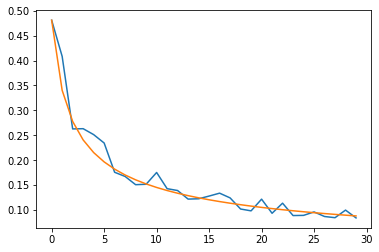

In [78]:
fun = RandomPoly(3)
integral = fun.integral(0,1)
errors = []
target = []
for i in range(1,31):
  av_error = 0
  for j in range(100):
    av_error += abs(integral - mc_quadrature(fun.function, i))
  errors.append(av_error/100)
  target.append(1*errors[0]/pow(i,0.5))
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(np.array(range(30)), errors)
sub.plot(np.array(range(30)), target)
print()

### Monte Carlo quadrature over reference triangle

This test is the same as the previous. 

f(x) = -4x^2 + 1y^2 + 2xy + 4x + 3y + 2



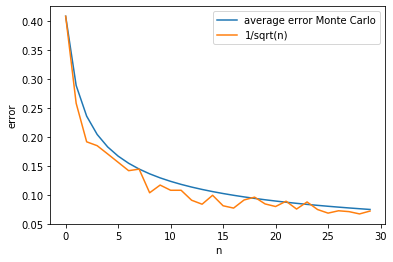

In [105]:
fun = Random2dimPoly()
integral = fun.integral()
errors = []
target = []
for i in range(1,31):
  av_error = 0
  for j in range(100):
    av_error += abs(integral - mc_quadrature_tri(fun.function, i))
  errors.append(av_error/100)
  target.append(1*errors[0]/pow(i,0.5))
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(np.array(range(30)), target, label = "1/sqrt(n)" )
sub.plot(np.array(range(30)), errors, label = "average error Monte Carlo")
sub.set_xlabel("n")
sub.set_ylabel("error")
sub.legend()
print()

# **Discussion**

All tests were successful and show that the methods as implemented work. The expected convergence rate for Monte-Carlo was reached almost exactly, and gets more accurate as the number of samples for each $n$ quadrature points is increased. 